In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from math import sqrt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 1.  Laying the land


In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df = train_df[train_df["Income in EUR"] > 0]
train_df = train_df[train_df["Age"] < 80]
to_drop = train_df[((train_df.Gender == 'unknown') | (pd.isnull(train_df.Gender))) & ((pd.isnull(train_df.Profession)) & ((pd.isnull(train_df['University Degree']))))].index
train_df.drop(to_drop,inplace= True)
train_df.rename({'Income in EUR':'income'}, axis=1, inplace=True)
train_target = train_df['income']
train_labels = train_df.drop('income', 1)

test_df = pd.read_csv('./data/test.csv')
test_df.rename({'Income':'income'}, axis=1, inplace=True)
test_target = test_df['income']
test_labels = test_df.drop('income', 1)

df = pd.concat([train_labels, test_labels], sort = False)
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.lower()
pd.DataFrame({"Train": {"rows":train_df.shape[0], "col":train_df.shape[1]} , "Test": {"rows":test_df.shape[0], "col":test_df.shape[1]}}
            )

,Train,Test
col,12,12
rows,110044,73230


In [3]:
df.head(1)

,instance,year_of_record,gender,age,country,size_of_city,profession,university_degree,wears_glasses,hair_color,body_height_[cm]
0,1,1997.0,0,41.0,Belarus,1239930,steel workers,Bachelor,0,Blond,193


Number of rows(185223) and columns(12) 

In [4]:
df.shape

(183274, 11)

All the columns in the dataset with the number of records and their respective data types.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183274 entries, 0 to 73229
Data columns (total 11 columns):
instance             183274 non-null int64
year_of_record       182546 non-null float64
gender               171143 non-null object
age                  182995 non-null float64
country              183274 non-null object
size_of_city         183274 non-null int64
profession           182767 non-null object
university_degree    171177 non-null object
wears_glasses        183274 non-null int64
hair_color           171247 non-null object
body_height_[cm]     183274 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 16.8+ MB


Percentage of missing values in each column: 

In [6]:
(df.isnull()/df.shape[0]).sum() * 100

instance             0.000000
year_of_record       0.397219
gender               6.619051
age                  0.152231
country              0.000000
size_of_city         0.000000
profession           0.276635
university_degree    6.600500
wears_glasses        0.000000
hair_color           6.562306
body_height_[cm]     0.000000
dtype: float64

# 2. Missing values 

Text(0.5, 1.0, 'Number of missing values')

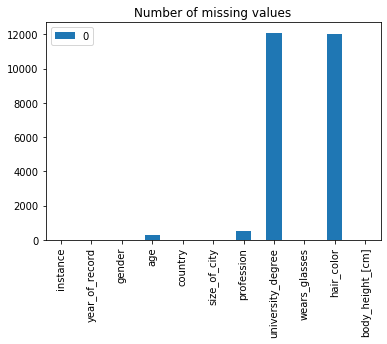

In [11]:
pd.DataFrame(df.isnull().sum()).plot.bar().set_title("Number of missing values")
# (df.isnull()/df.shape[0]).sum() * 100

### Year of record

In [7]:
df.year_of_record.bfill(inplace = True)

### Gender

In [8]:
df.gender.value_counts()

male       70304
female     44368
other      44233
unknown    11066
0           1172
Name: gender, dtype: int64

In [9]:
df.loc[df['gender'] == '0', 'gender'] = 'male'
df.gender.fillna('unknown', inplace=True)

In [11]:
df.gender.value_counts()

male       71476
female     44368
other      44233
unknown    23197
Name: gender, dtype: int64

### Age

In [12]:
df.age.describe()

count    182995.000000
mean         36.971125
std          15.512092
min          14.000000
25%          24.000000
50%          35.000000
75%          47.000000
max         126.000000
Name: age, dtype: float64

In [13]:
df.age.fillna(df.age.median(), inplace=True)

### Profession


In [14]:
df.profession.bfill(inplace = True)

### Hair color

In [15]:
df.loc[df['hair_color'] == '0', 'hair_color'] = 'Unknown'
df.hair_color.bfill(inplace = True)
df.hair_color.unique()

array(['Blond', 'Black', 'Brown', 'Red', 'Unknown'], dtype=object)

### University Degree

In [16]:
df.university_degree.bfill(inplace = True)

In [17]:
df.isnull().sum()

instance             0
year_of_record       0
gender               0
age                  0
country              0
size_of_city         0
profession           0
university_degree    0
wears_glasses        0
hair_color           0
body_height_[cm]     0
dtype: int64

# 3. Correlation of numerical values with income in Training dataset

In [18]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Instance,Year of Record,Age,Size of City,Wears Glasses,Body Height [cm],income
Instance,1,-0.0019282,0.00075427,-0.00427857,0.000791395,-0.00159089,0.00320229
Year of Record,-0.0019282,1,-0.000616228,0.00282939,-0.00210436,0.00203644,0.166983
Age,0.00075427,-0.000616228,1,0.00612141,-0.00131969,-0.00234983,0.179542
Size of City,-0.00427857,0.00282939,0.00612141,1,0.000737999,-0.00226304,0.0154095
Wears Glasses,0.000791395,-0.00210436,-0.00131969,0.000737999,1,0.00666906,0.00439741
Body Height [cm],-0.00159089,0.00203644,-0.00234983,-0.00226304,0.00666906,1,0.0724329
income,0.00320229,0.166983,0.179542,0.0154095,0.00439741,0.0724329,1


# 4. Dropping Columns

In [19]:
df = df.drop(columns=["hair_color", "size_of_city", "wears_glasses", "body_height_[cm]"])

# 5. Encoding

### Year of record

In [20]:
df['yor'] = pd.cut(df['year_of_record'], bins = 5)
df['yor'] = df['yor'].astype(str).str.strip('()[]')
df['yor'] = df['yor'].astype(str).str.replace(', ', '-')
df = pd.concat([df.drop('yor', 1), pd.get_dummies(df.yor, prefix='year_range', drop_first = True)], axis=1)
df = df.drop('year_of_record', 1)

### Gender

In [21]:
df = pd.concat([df.drop('gender', 1), pd.get_dummies(df.gender, prefix='gender', drop_first = True)], axis=1)

### Country

In [22]:
df = pd.concat([df, pd.get_dummies(df.country, prefix='country')], axis=1)
df = df.drop('country', 1)

### Profession

In [23]:
train = df[0:110044]
ce_target = ce.TargetEncoder(cols = ['Profession'])
df['profession'] = ce_target.fit_transform(train_df, train_df['income'])

### University Degree

In [24]:
df = pd.concat([df.drop('university_degree', 1), pd.get_dummies(df.university_degree, prefix='edu')], axis=1)

# 6. Scaling Features

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [26]:
train_features = df[0:110044]
test_features = df[110044:]


# rf_random = RandomizedSearchCV(estimator = reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(train_features, train_target)
# pred = reg.predict(train_features)
# rms = sqrt(mean_squared_error(train_target, pred))
# print(rms)


reg = RandomForestRegressor(n_estimators=10, random_state=42, min_samples_split=2, n_jobs=-1)
reg.fit(train_features, train_target)
pred = reg.predict(train_features)
rms = sqrt(mean_squared_error(train_target, pred))
print(rms)

36408.60273855427


In [27]:
pred = reg.predict(test_features)
dff = pd.DataFrame({'Income':pred})
dff.to_csv('op_1.csv',index=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').